In [268]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from sklearn.model_selection import train_test_split

In [269]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

### Choose which sites to train the SVR model on
Can be all available, or a defined list 'site_list' passed, or single station as list e.g. ['CLN']<br>
Use all with an exclude list is another alternative

In [295]:
flist = glob(obdir + 'combined/*.pd')

# This can be a manual site list if desired
site_list = np.unique([f.split('/')[-1].split('_')[0] for f in flist])
site_list = ['CLN']

### For each site, choose which files to use
For now, we will only use one set of observations from each site so samples remain independent<br>
We can change this behavior down the road to use all or some intervals<br>
Favor 'short' for the shortest interval available e.g. 6h, 'long' for longest interval e.g. 24h

In [296]:
favor = 'short' #'long'

flist = []
for site in site_list:
    
    site_files = glob(obdir + 'combined/%s*.pd'%site)
    
    if len(site_files) > 1:
        if favor == 'short':
            flist.append(
                site_files[np.argmin([int(f.split('.')[-2].replace('h', '')) 
                    for f in site_files])])
            
        elif favor == 'long':
            np.argmax([int(f.split('.')[-2].replace('h', '')) for f in site_files])
    
    else:
        flist.append(site_files[0])
        
flist

['/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CLN_1999_2019.12h.pd']

### Establish which model variables and levels to use
This is entirely based on the model that the SVR will be applied to - maximize the predictor set<br>
Helpful to open a sample GFS/NAM/HRRR grid or profile to derive the variable list from

In [297]:
# For now we can reuse the fixed list from the proof-of-concept script
# But this needs to be made flexible
gfs_keys = [
       'VO1000', 'VO400', 'VO450', 'VO500', 'VO550', 'VO600', 'VO650',
       'VO700', 'VO750', 'VO800', 'VO850', 'VO900', 'VO925', 'VO950',
       'VO975', 'CAPE', 'DIR1000', 'DIR400', 'DIR450', 'DIR500', 'DIR550',
       'DIR600', 'DIR650', 'DIR700', 'DIR750', 'DIR800', 'DIR850',
       'DIR900', 'DIR925', 'DIR950', 'DIR975', 'Z1000', 'Z400', 'Z450',
       'Z500', 'Z550', 'Z600', 'Z650', 'Z700', 'Z750', 'Z800', 'Z850',
       'Z900', 'Z925', 'Z950', 'Z975', 'RH1000', 'RH400', 'RH450',
       'RH500', 'RH550', 'RH600', 'RH650', 'RH700', 'RH750', 'RH800',
       'RH850', 'RH900', 'RH925', 'RH950', 'RH975', 'SP', 'SPD1000',
       'SPD400', 'SPD450', 'SPD500', 'SPD550', 'SPD600', 'SPD650',
       'SPD700', 'SPD750', 'SPD800', 'SPD850', 'SPD900', 'SPD925',
       'SPD950', 'SPD975', 'T1000', '2T', 'T400', 'T450', 'T500', 'T550',
       'T600', 'T650', 'T700', 'T750', 'T800', 'T850', 'T900', 'T925',
       'T950', 'T975', 'TSFC', 'U1000', 'U400', 'U450', 'U500', 'U550',
       'U600', 'U650', 'U700', 'U750', 'U800', 'U850', 'U900', 'U925',
       'U950', 'U975', 'V1000', 'V400', 'V450', 'V500', 'V550', 'V600',
       'V650', 'V700', 'V750', 'V800', 'V850', 'V900', 'V925', 'V950',
       'V975', 'W1000', 'W400', 'W450', 'W500', 'W550', 'W600', 'W650',
       'W700', 'W750', 'W800', 'W850', 'W900', 'W925', 'W950', 'W975']

gfs_levels = [400, 450, 500,550,600, 650, 700, 750, 
              800, 850, 900, 925,950,975, 1000]

exclude_keys = ['2T', 'CAPE', 'Z']

exclude_keys = np.array([[k if ex in k[:len(ex)] else np.nan 
                          for ex in exclude_keys] for k in gfs_keys])
exclude_keys = exclude_keys.flatten()
exclude_keys = exclude_keys[exclude_keys != 'nan']

gfs_keys = np.array([k for k in gfs_keys if k not in exclude_keys])
gfs_keys

array(['VO1000', 'VO400', 'VO450', 'VO500', 'VO550', 'VO600', 'VO650',
       'VO700', 'VO750', 'VO800', 'VO850', 'VO900', 'VO925', 'VO950',
       'VO975', 'DIR1000', 'DIR400', 'DIR450', 'DIR500', 'DIR550',
       'DIR600', 'DIR650', 'DIR700', 'DIR750', 'DIR800', 'DIR850',
       'DIR900', 'DIR925', 'DIR950', 'DIR975', 'RH1000', 'RH400', 'RH450',
       'RH500', 'RH550', 'RH600', 'RH650', 'RH700', 'RH750', 'RH800',
       'RH850', 'RH900', 'RH925', 'RH950', 'RH975', 'SP', 'SPD1000',
       'SPD400', 'SPD450', 'SPD500', 'SPD550', 'SPD600', 'SPD650',
       'SPD700', 'SPD750', 'SPD800', 'SPD850', 'SPD900', 'SPD925',
       'SPD950', 'SPD975', 'T1000', 'T400', 'T450', 'T500', 'T550',
       'T600', 'T650', 'T700', 'T750', 'T800', 'T850', 'T900', 'T925',
       'T950', 'T975', 'TSFC', 'U1000', 'U400', 'U450', 'U500', 'U550',
       'U600', 'U650', 'U700', 'U750', 'U800', 'U850', 'U900', 'U925',
       'U950', 'U975', 'V1000', 'V400', 'V450', 'V500', 'V550', 'V600',
       'V650', 'V700', 

### Import the compiled data
Prune unused variables on import based on the list above<br>
Sub-surface levels have already been dealt with in the compilation script - modify methods there<br>
Note that 12 vs 24 hour intervals have also been dealt with above, if both desired... write that in

In [560]:
use_var_type = ['mean']#, 'max', 'min']

data = []
for f in flist:
    
    site = f.split('/')[-1].split('_')[0]
    interval = int(f.split('/')[-1].split('.')[-2].replace('h', ''))
    
    df = pd.read_pickle(f)

    keys = ['slr%d'%interval, 'swe%d_mm'%interval]
    
    keys.extend(np.hstack([[k for k in df.keys() 
                  if ((vt in k) & (k.split('_')[0] in gfs_keys))] 
                 for vt in use_var_type]))

    df = df.loc[:, keys].rename(columns={[k for k in keys if 'swe' in k][0]:'swe_mm'})
    df = df.rename(columns={[k for k in keys if 'slr' in k][0]:'slr'})
    
    # df.insert(0, 'site', np.full(df.index.size, fill_value=site, dtype='U10'))
    doy = [int(pd.to_datetime(d).strftime('%j')) for d in df.index]
    df.insert(2, 'day_of_year', doy)
    
    data.append(df.reset_index().drop(columns='time'))

data = pd.concat(data, sort=False)

# Treat the mean value as the instantaneous value for later applications,
# we can change this behavior later on if desired. 
# An alternate method would be to keep the 'mean' tag through training 
# and choose behavior upon application
data = data.rename(columns={k:k.replace('_mean', '') for k in data.keys()})

data.head()

,slr,swe_mm,day_of_year,T400,U400,V400,VO400,W400,SPD400,T450,...,VO750,W750,SPD750,T800,U800,V800,VO800,W800,SPD800,SP
0,9.523809,10.668,312,245.751221,14.262792,18.845314,-0.000007,-0.282659,23.807833,251.453506,...,-0.000228,0.009979,11.576412,286.184265,-0.407485,5.358132,-0.000366,0.256965,5.541474,80253.921875
1,11.320755,13.462,321,245.860687,13.253074,27.635181,-0.000044,-0.518515,30.789095,251.604340,...,-0.000283,-0.137410,11.845341,286.156799,-0.658640,4.628677,-0.000338,0.191280,5.377541,79608.828125
2,8.695652,5.842,324,247.194550,23.618073,13.456594,-0.000019,0.183329,27.394947,253.433563,...,-0.000208,-0.100848,10.392151,281.588654,-1.551895,3.541852,-0.000251,0.402385,3.930658,80416.054688
3,18.181818,2.794,324,243.966476,26.156818,9.112763,0.000035,-0.103810,28.957607,249.460709,...,-0.000032,-0.405258,5.438491,277.557007,0.522875,1.790523,-0.000107,0.006187,2.677736,80313.203125
4,16.071428,7.112,325,242.414658,25.918653,-0.349203,0.000037,-0.012761,26.516172,245.851898,...,-0.000012,0.106172,2.433492,275.800568,-0.293900,-0.477268,0.000029,0.294072,1.532066,80073.867188


<hr><hr>

### Investigate basic bulk statistics and linear correlations
Quanitfy how certain variables are related and produce plots to visualize this<br>

#### *Removed: Normalize/Standardize
Moved down to where datasets are split. If need be we can normalize for the plots below here too...

#### Pair Plots

#### Correlation Matrix, R2 Matrix

#### Linear Correlation Verical Plots, R2 Vertical Plots

#### Identify autocorrelated and other dependent predictors
Mask these if desired

<hr><hr>

### Split Train/Test/Validate Sets
If we want to expand the hyperparameter tuning, we can test for sensitivity to random sample<br>
by looping from bottom of code block back to here<br>
*INVESTIGATE: Behavior of random_state in TTS

In [561]:
# Split into train/test sets
train_size, test_size = 0.70, 0.30
X_train, X_test = train_test_split(data, test_size=test_size, train_size=train_size, random_state=None)

# Perform a secondary split if separate validation set required

# Split off the target variable now that TTsplit is done
y_train, y_test = X_train.pop('slr'), X_test.pop('slr')

print('Train: {}\nTest: {}\nValidate: {}'.format(X_train.shape[0], X_test.shape[0], None))

train_stats = X_train.describe().T
train_stats.head(10)

Train: 1165
Test: 500
Validate: None


,count,mean,std,min,25%,50%,75%,max
swe_mm,1165.0,10.846999,8.069140,1.524000,4.826000,8.636000,14.224000,57.911999
day_of_year,1165.0,153.682403,133.811783,1.000000,47.000000,88.000000,317.000000,365.000000
T400,1165.0,239.926178,4.901735,224.297226,236.586884,240.205078,243.650543,253.353546
U400,1165.0,19.126438,11.264865,-12.959023,10.939073,19.087900,26.725712,59.784084
V400,1165.0,3.652757,14.885930,-54.728245,-5.439290,5.109018,13.668539,45.693340
VO400,1165.0,0.000012,0.000053,-0.000108,-0.000025,0.000001,0.000039,0.000263
W400,1165.0,-0.087951,0.294399,-1.324921,-0.227944,-0.035071,0.096884,0.873093
SPD400,1165.0,25.360518,10.352661,2.404542,17.645409,25.459175,32.645451,67.926323
T450,1165.0,246.025269,4.947752,230.203537,242.766846,246.423233,249.657486,258.938995
U450,1165.0,16.781029,9.587563,-10.083364,9.851603,16.842905,23.164368,52.233501


### Normalize/Standardize the data
We are using z-score normalization for now but other methods exist<br>
This is an absolute must for working with any of the ML models available to us<br>
Normalize based on the TRAINING dataset

In [562]:
def zscore(x, mu, sigma):
    '''Standardization'''
    return (x - mu) / sigma

In [563]:
X_train_norm = zscore(X_train, train_stats['mean'], train_stats['std'])
X_test_norm = zscore(X_test, train_stats['mean'], train_stats['std'])

X_train_norm.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
swe_mm,1165.0,7.674418e-09,1.000000,-1.155389,-0.746176,-0.274007,0.418508,5.832715
day_of_year,1165.0,-1.219816e-17,1.000000,-1.141024,-0.797257,-0.490857,1.220502,1.579215
T400,1165.0,-1.450393e-05,1.000000,-3.188453,-0.681247,0.056898,0.759806,2.739309
U400,1165.0,-1.845940e-06,1.000000,-2.848277,-0.726805,-0.003421,0.674600,3.609244
V400,1165.0,1.409023e-07,0.999999,-3.921891,-0.610781,0.097828,0.672836,2.824183
VO400,1165.0,1.171628e-08,1.000000,-2.290911,-0.703757,-0.206529,0.503122,4.757345
W400,1165.0,2.285953e-07,1.000000,-4.201686,-0.475524,0.179619,0.627840,3.264433
SPD400,1165.0,1.780759e-06,1.000000,-2.217398,-0.745230,0.009530,0.703677,4.111581
T450,1165.0,-4.394883e-06,1.000000,-3.197761,-0.658566,0.080433,0.734115,2.610019
U450,1165.0,1.740609e-06,1.000000,-2.802005,-0.722752,0.006454,0.665794,3.697757


Print out plots describing the variability in the data (+ before/after normalization?)<br>
It would be valuable to do a similar set of/novel comparison plots with the ERA5 vs GFS<br>
for each variable/level in the validation script (separate from and following this script)

### EOF/PCA Reduction of highly dimensional data
There are implementations of atmospheric data in ML models that heavily leverage<br>
EOFs to reduce highly dimensional data to simpler components<br>
Evaluate if this is viable here as it will be applied to raw variables later on

### Use LASSO/Ridge regression to determine predictor rank/impact
L1/L2 Parameter Tuning -- Use to select relevant predictors, reduce irrelevant to zero, rank by influence

In [564]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_norm, y_train)

lr_train_score = lr.score(X_train_norm, y_train)
lr_test_score = lr.score(X_test_norm, y_test)

print('Linear Regression Train Score: %.3f'%lr_train_score)
print('Linear Regression Test Score: %.3f'%lr_test_score)

Linear Regression Train Score: 0.439
Linear Regression Test Score: 0.342


In [565]:
from sklearn.linear_model import Ridge

# The higher the alpha value, more restriction on the coefficients; 
# low alpha > more generalization, coefficients are barely restricted
rr_alpha_tune = []
for alpha in np.append(np.arange(0.01, 1, 0.01), np.arange(1, 1000, 1)):

    rr = Ridge(alpha=alpha)
    rr.fit(X_train, y_train)

    rr_train_score = rr.score(X_train, y_train)
    rr_test_score = rr.score(X_test, y_test)
    
    rr_alpha_tune.append([alpha, rr_train_score, rr_test_score, rr])
rr_alpha_tune = np.array(rr_alpha_tune)

alpha, rr_train_score, rr_test_score, rr = rr_alpha_tune[np.argmax(rr_alpha_tune[:, 2])]
print('Ridge Regression alpha: %.3f'%alpha)
print('Ridge Regression Train Score: %.3f'%rr_train_score)
print('Ridge Regression Test Score: %.3f'%rr_test_score)

Ridge Regression alpha: 66.000
Ridge Regression Train Score: 0.414
Ridge Regression Test Score: 0.367


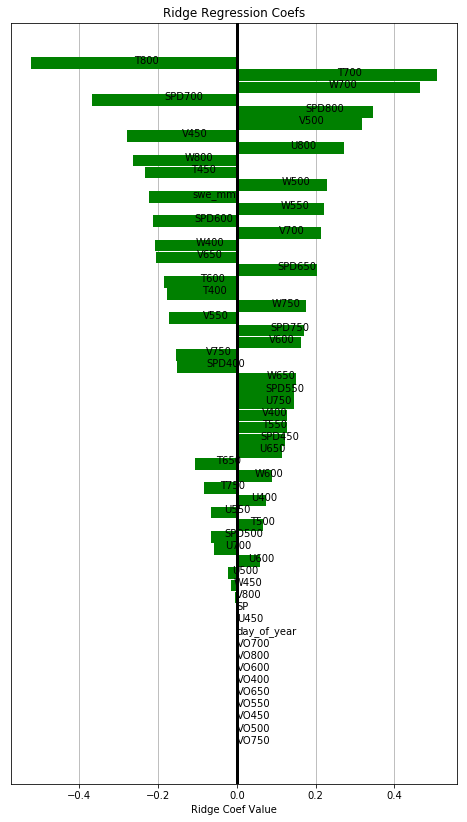

In [599]:
fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(rr.coef_))[::-1]
rr_coefs = rr.coef_[ranksort]
rr_keys = X_train_norm.keys()[ranksort]
mask = rr_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(rr_keys[mask], rr_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(rr_keys):
    if rr_coefs[i] != 0:
        ax.text(rr_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Ridge Regression Coefs')
ax.set_xlabel('Ridge Coef Value')
ax.grid(zorder=-1)

In [600]:
from sklearn.linear_model import Lasso

lasso_alpha_tune = []
for alpha in np.arange(0.001, .01, 0.001):

    lasso = Lasso(alpha=alpha, max_iter=10e5)
    lasso.fit(X_train_norm, y_train)

    lasso_train_score = lasso.score(X_train_norm, y_train)
    lasso_test_score = lasso.score(X_test_norm, y_test)
    lasso_coeff_used = np.sum(lasso.coef_ != 0)
    
    lasso_alpha_tune.append([alpha, lasso_train_score, lasso_test_score, lasso])
lasso_alpha_tune = np.array(lasso_alpha_tune)

alpha, lasso_train_score, lasso_test_score, lasso = lasso_alpha_tune[np.argmax(lasso_alpha_tune[:, 2])]
print('Lasso alpha: %.3f'%alpha)
print('Lasso Train Score: %.3f'%lasso_train_score)
print('Lasso Test Score: %.3f'%lasso_test_score)
print('Number of Features Used: %d'%lasso_coeff_used)

Lasso alpha: 0.009
Lasso Train Score: 0.426
Lasso Test Score: 0.367
Number of Features Used: 36


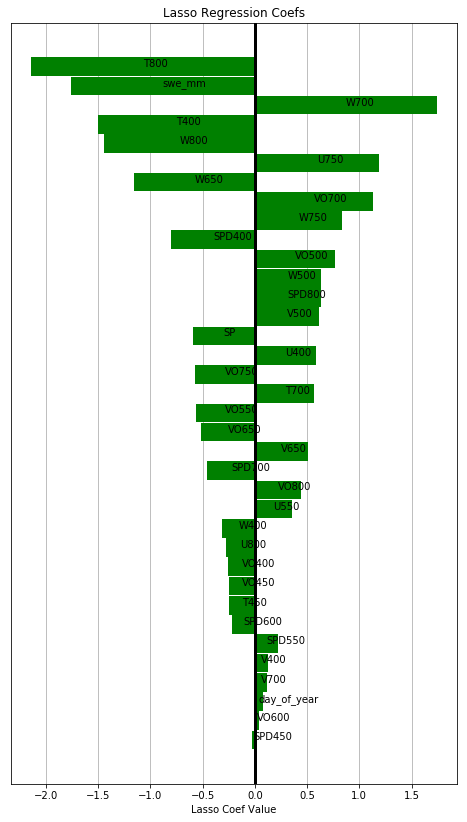

In [601]:
fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(lasso.coef_))[::-1]
lasso_coefs = lasso.coef_[ranksort]
lasso_keys = X_train_norm.keys()[ranksort]
mask = lasso_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(lasso_keys[mask], lasso_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(lasso_keys):
    if lasso_coefs[i] != 0:
        ax.text(lasso_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Lasso Regression Coefs')
ax.set_xlabel('Lasso Coef Value')
ax.grid(zorder=-1)

plt.show()

In [618]:
from sklearn.linear_model import ElasticNet

# Grid-search for best parameters? (alpha and l1_ratio)

elastic = ElasticNet(alpha=0.009, l1_ratio=0.1)
elastic.fit(X_train_norm, y_train)

elastic_train_score = elastic.score(X_train_norm, y_train)
elastic_test_score = elastic.score(X_test_norm, y_test)
elastic_coeff_used = np.sum(lasso.coef_ != 0)
    
print('Elastic Train Score: %.3f'%elastic_train_score)
print('Elastic Test Score: %.3f'%elastic_test_score)

Elastic Train Score: 0.428
Elastic Test Score: 0.366


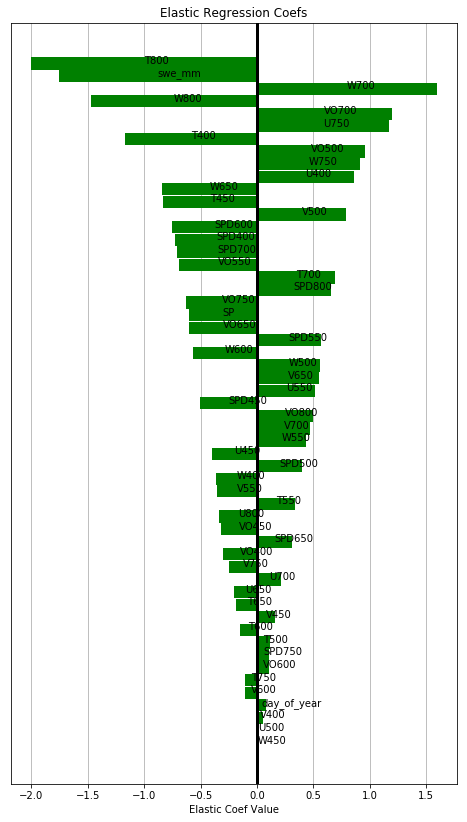

In [619]:
fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(8, 14))

ranksort = np.argsort(abs(elastic.coef_))[::-1]
elastic_coefs = elastic.coef_[ranksort]
elastic_keys = X_train_norm.keys()[ranksort]
mask = elastic_coefs != 0

ax.axvline(0, color='k', linewidth=3, zorder=11)
ax.barh(elastic_keys[mask], elastic_coefs[mask], color='green', zorder=10, height=0.97)

for i, k in enumerate(elastic_keys):
    if elastic_coefs[i] != 0:
        ax.text(elastic_coefs[i]/2, k, k, zorder=20)

ax.invert_yaxis()
ax.axes.get_yaxis().set_visible(False)
ax.set_title('Elastic Regression Coefs')
ax.set_xlabel('Elastic Coef Value')
ax.grid(zorder=-1)

plt.show()

#### If we want to use feature selection, we can do so here.
Can choose the model from which to take features, do so manually, or not at all (set equal to X_train.keys())

In [621]:
feature_selection = elastic_keys[mask]
feature_selection

Index(['T800', 'swe_mm', 'W700', 'W800', 'VO700', 'U750', 'T400', 'VO500',
       'W750', 'U400', 'W650', 'T450', 'V500', 'SPD600', 'SPD400', 'SPD700',
       'VO550', 'T700', 'SPD800', 'VO750', 'SP', 'VO650', 'SPD550', 'W600',
       'W500', 'V650', 'U550', 'SPD450', 'VO800', 'V700', 'W550', 'U450',
       'SPD500', 'W400', 'V550', 'T550', 'U800', 'VO450', 'SPD650', 'VO400',
       'V750', 'U700', 'U650', 'T650', 'V450', 'T600', 'T500', 'SPD750',
       'VO600', 'T750', 'V600', 'day_of_year', 'V400', 'U500', 'W450'],
      dtype='object')

<hr><hr>

### Implement Support Vector Regression Model
(Other ML models like ANN from keras, tensorflow, pytorch may be used in this block)

Implement a K-Fold Cross Validation to assess model performance (Optional, recommended)

Make the SVR model multiprocess friendly

Run SVR, collect output iterated over hyperparameters (C, epsilon)<br>
Specify the cost function/loss function used, tolerances, kernel, error metric, etc

Plot model performance over time, cost/loss function evolution and skill

Plot SVR output with hyperparameters (C, epsilon)<br>
Apply a grid-search method to select best performing parameters

### Describe final trained SVR model
Descriptive plots of predictor coefficient rank/influence<br>
Print out model parameters, error metrics, skill scores

### Save out a usable model along with the input parameters for application
Save with a descriptive filename and a metadata text file!<br>
This will make swapping out models for evaluation much simpler